# Compute Knowledge Graphs of the World

Author: KlausGPaul (R²Data Labs, Berlin AI Hub, Rolls-Royce Deutschland for Emergent Alliance Ltd)

This notebook computes the hierarchy or Countries. and their neighbourhood relationships, at various levels, countries, regions, districts. It creates a graph representation that can be traversed according to an entity belonging to another entity, or an entity neighbouring an entity. Uses cases are
* geolocation and neighbourhood relations (e.g. infection status)
* computation of the notion of a border (travel restrictions)
* airtravel
* international trade
* mobility themes (e.g. weekend travel)

This notebook requires data to be downloaded from
* https://gadm.org/download_world.html, this is a roughly 2GB compressed shapefile file found [here](https://biogeo.ucdavis.edu/data/gadm3.6/gadm36_shp.zip). Note this file has vector data which contains defects. See also https://github.com/AmericanRedCross/simplegadm
* http://www.naturalearthdata.com/downloads/10m-cultural-vectors/ this is a 4 MB compressed shapefile for sovereignities found [here](https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_sovereignty.zip)
* ARCGIS for [Local Authority Districts (December 2018) Boundaries UK BFC](https://covid19.esriuk.com/datasets/fef73aeaf13c417dadf2fc99abcf8eef_0?geometry=-66.025%2C44.785%2C60.186%2C62.639)
* NPGEO Corona for [Germany boundaries shapefiles](https://npgeo-corona-npgeo-de.hub.arcgis.com/search?groupIds=4275917ff19f4445b8522d3ce8dfa0d3), note that Berlin Bezirke data has to be downloaded separately, then fused after the reference coordinate system has been adjusted to match the Germany data
* [Openpolis Italy geojson data](https://github.com/openpolis/geojson-italy/blob/master/geojson/limits_IT_provinces.geojson)
* [French departement data from Opentreetmap](https://www.data.gouv.fr/fr/datasets/contours-des-departements-francais-issus-d-openstreetmap/)
The actual data download links are in the code below.

This notebook requires an environment which has
* geopandas >= 0.7.0
* pandas
* pyarrow or fastparquet
* networkx

installed.

In addition, it is recommended to also install
* pyvis, which will require
* jsonpickle
* descartes

There is a lot to be said about what a country, a nation, a sovereignity is. This notebook is created to support 2020 COVID-19 disease outbreak modelling and its primary purpose is to compute neighbourhood relationships for country with health data at detail level below a nation. Simplifications will apply.

Please ensure your intended use to comply with the license holders of the data, such as
* [Natural Earth Terms of Use](http://www.naturalearthdata.com/about/terms-of-use/)

The information in theis notebook is provided in good faith and has been diligently checked for significant mistakes. Use of it is only recommended for educational and research purpose, any other use is at the risk of the user, not the author. 

In [1]:
# uncomment as required, ideally, consider setting up a new jupyter environment
#import sys
#!pip install --prefix {sys.prefix} geopandas

In [2]:
import geopandas as gpd
import pandas as pd
import fiona
import pyproj
import networkx as nx
from pathlib import Path
import os
from ipywidgets import Dropdown, HBox, HTML
from IPython.display import display, Image
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import HoverTool, Text, Circle, MultiLine
try: # bokeh > 1.0.4
    from bokeh.plotting import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes
except:
    from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes
try:
    import pyvis
except:
    !pip install jsonpickle pyvis
    import pyvis
from ipywidgets import IntProgress
from IPython.display import display
import requests
import zipfile
import io
import urllib
try:
    from project_lib import Project
    CLOUDPAK = True # our work was jointly carried out between IBM and Rolls-Royce and we used the IBM CloudPak environment
except:
    CLOUDPAK = False

#import threading
import numpy as np
#from threading import Thread
import multiprocessing as mp
import inspect
import importlib
import time
import pickle
import copy

try:
    import descartes
except:
    !pip install descartes
    import descartes

output_notebook()

Loading BokehJS ...

## Data layout

We generally do data pipelines in our day-to-day work, with the occasional data trial as one-off investigations. To keep up with the complexity of downloaded, processed, cleaned, and enriched data files we use an onion-like model of data layers which desribes the various processing and abstraction levels. To remain abstract, we chose the solar system model to "name" data abstraction levels as it flows through our systems:-
* _Sun_ data are generally raw, unaltered, possibly not yet clean data. Some teams and data engineers may refer to _ingestion area_, or _landing zone_ for that layer
* _Mercury_ data are the first derivative of _Sun_ data, this is often called _istaging_ in data engineering terms. Us data scientists generally should work with _Mercury_ data unless _Sun_ data was known good. _Mercury_ would deal with missing numbers, #NAN, empty lines, take care of date formatting, and useful column names/schemas
* _Venus_ may be a derivative of _Mercury_ this could be the result of a machine learning or analytics step, such as the output file of a k-means clustering step, smoothed data etc.
* _Earth_ data is then, I guess to see the point....

## Helper Library for Graphs

This code is used across the notebook. We decided to use networkx to allow use of this notebook without prior installation of graph databases, Spark clusters, or complex libraries with a steep learning curve. As such, knowledge graph functionality will be limited as it makes no sense to develop yet another library.

In [3]:
class THEWORLD():
    """Helper class to map country identifiers to know entities.
    """
    def __init__(self,ROOTFOLDER):
        """Set up folders and directories and load Natural Earth geodataframes.
        """
        self.ROOT = os.path.join(ROOTFOLDER,"sun/geo/naturalearthdata.com_downloads/")
        self.dfSovereignities = gpd.read_file(os.path.join(self.ROOT,"ne_10m_admin_0_sovereignty.shp"))
        self.dfWorld = gpd.read_file(os.path.join(self.ROOT,"ne_10m_admin_0_countries.shp"))
        self.dfMapdata = gpd.read_file(os.path.join(self.ROOT,"ne_10m_admin_0_map_units.shp"))
                                       
    def search_info(self,CODE,NAME):
        """This is a manually curated list of mappings for the purpose of COVID-19 neighbourhood relations. When using Sovereignity data, which we found useful,
        one encounters geographical entities we rarely encountered before, such as Akrotiri on Cyprus is a British Overseas Territory on the Island of Cyprus,
        see https://en.wikipedia.org/wiki/Akrotiri_and_Dhekelia . For the sake of COVID-19, we map it to Cyprus.
        """
        if len(self.dfWorld[self.dfWorld.SOV_A3 == CODE]) == 1:
            result = self.dfWorld[self.dfWorld.SOV_A3 == CODE]
            retval = {"CODE":CODE,"REGION_UN":result["REGION_UN"].values[0],"SUBREGION":result["SUBREGION"].values[0],"NAME":result["ADMIN"].values[0],"name":NAME}
        elif len(self.dfWorld[self.dfWorld.ADM0_A3 == CODE]) == 1:
            result = self.dfWorld[self.dfWorld.ADM0_A3 == CODE]
            retval = {"CODE":CODE,"REGION_UN":result["REGION_UN"].values[0],"SUBREGION":result["SUBREGION"].values[0],"NAME":result["ADMIN"].values[0],"name":NAME}
        elif len(self.dfSovereignities[self.dfSovereignities.ADM0_A3 == CODE]) == 1:
            result = self.dfSovereignities[self.dfSovereignities.ADM0_A3 == CODE]
            retval = {"CODE":CODE,"REGION_UN":result["REGION_UN"].values[0],"SUBREGION":result["SUBREGION"].values[0],"NAME":result["ADMIN"].values[0],"name":NAME}
        elif len(self.dfMapdata[self.dfMapdata.ISO_A3 == CODE]) == 1:
            result = self.dfMapdata[self.dfMapdata.ISO_A3 == CODE]
            retval = {"CODE":CODE,"REGION_UN":result["REGION_UN"].values[0],"SUBREGION":result["SUBREGION"].values[0],"NAME":result["ADMIN"].values[0],"name":NAME}
        elif len(self.dfMapdata[self.dfMapdata.SOV_A3 == CODE]) == 1:
            result = self.dfMapdata[self.dfMapdata.SOV_A3 == CODE]
            retval = {"CODE":CODE,"REGION_UN":result["REGION_UN"].values[0],"SUBREGION":result["SUBREGION"].values[0],"NAME":result["ADMIN"].values[0],"name":NAME}
            
        elif CODE == "XAD": # Akrotiri and Dhekelia. two military bases on Cyprus
            result = self.dfSovereignities[self.dfSovereignities.ISO_A3 == "CYP"]
            retval = {"CODE":CODE,"REGION_UN":result["REGION_UN"].values[0],"SUBREGION":result["SUBREGION"].values[0],"NAME":NAME,"name":NAME}
            
        elif CODE == "XNC": # Northen Cyprus, w/o getting political, use Cyprus
            result = self.dfSovereignities[self.dfSovereignities.ISO_A3 == "CYP"]
            retval = {"CODE":CODE,"REGION_UN":result["REGION_UN"].values[0],"SUBREGION":result["SUBREGION"].values[0],"NAME":NAME,"name":NAME}
            
        elif CODE == "XCA": # Caspian Sea, lets use Kazakhstan
            result = self.dfWorld[self.dfWorld.ISO_A3 == "KAZ"]
            retval = {"CODE":CODE,"REGION_UN":result["REGION_UN"].values[0],"SUBREGION":result["SUBREGION"].values[0],"NAME":NAME,"name":NAME}
            
        elif CODE == "XKO": #Kozovo, use Serbia
            result = self.dfWorld[self.dfWorld.ISO_A3 == "SRB"]
            retval = {"CODE":CODE,"REGION_UN":result["REGION_UN"].values[0],"SUBREGION":result["SUBREGION"].values[0],"NAME":NAME,"name":NAME}
            
        elif CODE == "PSE": # Palestine, use Israel
            result = self.dfWorld[self.dfWorld.ISO_A3 == "ISR"]
            retval = {"CODE":CODE,"REGION_UN":result["REGION_UN"].values[0],"SUBREGION":result["SUBREGION"].values[0],"NAME":NAME,"name":NAME}
            
        elif CODE == "XCL": # Clipperton Island, actually not inhabited. Lets use American Samoa
            result = self.dfWorld[self.dfWorld.ISO_A3 == "ASM"]
            retval = {"CODE":CODE,"REGION_UN":result["REGION_UN"].values[0],"SUBREGION":result["SUBREGION"].values[0],"NAME":NAME,"name":NAME}
            
        elif CODE == "XPI" or CODE == "XSP": # Paracel Islands and Spratly Islands, South China sea, could be China, Viet Nam, Taiwan
            result = self.dfWorld[self.dfWorld.ISO_A3 == "PHL"]
            retval = {"CODE":CODE,"REGION_UN":result["REGION_UN"].values[0],"SUBREGION":result["SUBREGION"].values[0],"NAME":NAME,"name":NAME}
            
        else:
            retval = {"CODE":CODE,"error":True,"name":NAME}
        return retval

    
def find_node_by_attribute_value(graph,attribute,value,kind=""):
    for n,d in graph.nodes(data=True):
        if attribute not in d.keys():
            continue
        elif kind != "":
            if d[attribute] == value and d["kind"] == kind:
                retval = n
                break
        else:
            if d[attribute] == value:
                retval = n
                break
    else:
        retval = None
        
    return retval

def find_edges_of_kind(graph,kind):
    return [(u,v) for u,v,d in graph.edges(data=True) if d['kind']==kind]

def find_edges_of_key_value(graph,key,value):
    retval = []
    for edge in graph.edges:
        edge_dict = graph.edges[edge]
        print(edge,edge_dict)
        if edge_dict.get(key) is None:
            pass
        elif edge_dict.get(key) == value:
            retval.append(edge)
            #print(edge)
    return retval

def find_nodes_of_kind(graph,kind):
    retval = []
    for u,d in graph.nodes(data=True):
        if 'kind' in d.keys():
            if d['kind'] == kind:
                retval.append(u)
    return retval

def find_nodes_of_key_value(graph,key,value):
    retval = []
    for node in graph.nodes:
        node_dict = graph.nodes[node]
        #print(node,node_dict)
        if node_dict.get(key) is None:
            pass
        elif node_dict.get(key) == value:
            retval.append(node)
            #print(node)
    return retval

def create_subgraph_of_nodes(graph,nodes,edges):
    return nx.restricted_view(graph,set(graph.nodes).difference(list(nodes)),set(graph.edges).difference(list(edges))).copy()

## Download Data

In [4]:
if CLOUDPAK: # This runs on a kubernetes cluster and we need to point to the persistence store
    ROOTFOLDER = "/project_data/data_asset/"
else:
    ROOTFOLDER = "./"

In [5]:
def download_and_unzip(url,root,subfolder,filename=""):
    ROOT = os.path.join(root,subfolder)
    Path(ROOT).mkdir(exist_ok=True,parents=True)
    if filename == "":
        filename = os.path.split(urllib.parse.urlparse(url).path)[1]
    else:
        pass
    
    downloaded_file = os.path.join(ROOT,filename)
    if not os.path.exists(downloaded_file):
        r = requests.get(url)
        if r.ok:
            content = r.content
            with open(downloaded_file,"w+b") as outfile:
                outfile.write(content)
        else:
            return False
    else:
        with open(downloaded_file,"rb") as infile:
            content = infile.read()
    
    with zipfile.ZipFile(downloaded_file) as zf:
        zf.extractall(ROOT)
        
    return True

required_data = ["https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip",
                "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_map_subunits.zip",
                "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_sovereignty.zip",
                "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_1_states_provinces.zip",
                "https://opendata.arcgis.com/datasets/fef73aeaf13c417dadf2fc99abcf8eef_0.zip", # UK
                "https://opendata.arcgis.com/datasets/248e105774144a27aca2dfbfe080fc9d_0.zip", # Germany Kreisgrenzen 2019
                "https://opendata.arcgis.com/datasets/9f5d82911d4545c4be1da8cab89f21ae_0.zip", # Berlin
                #"http://www.istat.it/storage/cartografia/confini_amministrativi/generalizzati/Limiti01012020_g.zip", # Italy, multiple levels
                #"http://www.istat.it/storage/cartografia/basi_territoriali/localita-italiane-shp/Localita_11_WGS84.zip", # Italy the above has conflicts
                #"http://www.istat.it/storage/cartografia/basi_territoriali/aree-subcomunali-xls-shp/ASC2011_WGS84.zip", # Another Italy
                #"https://www.data.gouv.fr/fr/datasets/r/eb36371a-761d-44a8-93ec-3d728bec17ce", # France, NB, need a file name
                "http://osm13.openstreetmap.fr/~cquest/openfla/export/departements-20180101-shp.zip", # France
                ]

for rd in required_data:
    filename = ""
    if "naturalearth" in rd:
        sub_root = "sun/geo/naturalearthdata.com_downloads"
    elif "arcgis" in rd:
        sub_root = "sun/geo/arcgis.com_datasets"
    elif "istat.it" in rd:
        sub_root = "sun/geo/istat.it"
    elif "gouv.fr" in rd:
        sub_root = "sun/geo/data.gouv.fr"
    elif "osm13.openstreetmap.fr" in rd:
        sub_root = "sun/geo/osm13.openstreetmap.fr"
        #filename = "departements-20180101.shp"
    if download_and_unzip(rd,ROOTFOLDER,sub_root,filename=filename):
        print(end=".")
    else:
        print("problem downloading {}".format(rd),end=" ")

ROOT = os.path.join(ROOTFOLDER,"sun/geo/geojson-italy/geojson")
Path(ROOT).mkdir(exist_ok=True,parents=True)
if not os.path.exists(os.path.join(ROOT,"limits_IT_provinces.geojson")):
    r = requests.get("https://github.com/openpolis/geojson-italy/raw/master/geojson/limits_IT_provinces.geojson")
    if r.ok:
        with open(os.path.join(ROOT,"limits_IT_provinces.geojson"),"w+t") as outfile:
            outfile.write(r.text)
    else:
        print("problem downloading {}".format("https://github.com/openpolis/geojson-italy/raw/master/geojson/limits_IT_provinces.geojson"),end=" ")
        
ROOT = os.path.join(ROOTFOLDER,"sun/geo/geojson-south-korea/geojson")
Path(ROOT).mkdir(exist_ok=True,parents=True)
if not os.path.exists(os.path.join(ROOT,"skorea-provinces-2018-geo.json")):
    r = requests.get("https://raw.githubusercontent.com/southkorea/southkorea-maps/master/kostat/2018/json/skorea-provinces-2018-geo.json")
    if r.ok:
        with open(os.path.join(ROOT,"skorea-provinces-2018-geo.json"),"w+t") as outfile:
            outfile.write(r.text)
    else:
        print("problem downloading {}".format("https://raw.githubusercontent.com/southkorea/southkorea-maps/master/kostat/2018/json/skorea-provinces-2018-geo.json"),end=" ")
        
print("Downloaded all data")

........Downloaded all data


# Compute UN Regions, Subregions, and put Countries onto the World Map

This does include entries like Clipperton Island, who's existence was unknown to the author until recently. It is actually not inhabited, so should remain unaffected by COVID-19, but it is good to have a complete dataset.

# Build Graph

This builds up data structures as a geo graph. The hierarchy, specifed by the node `kind` attribute
* continent
* subregion
* country
* state

The edges are relations of `kind`, taken from https://schema.org/Country
* containsPlace
* geoTouches

The class hierarchy is thus

`Europe --containsPlace--> Western Europe --containsPlace--> France`

and

`Netherlands -->geoTouches--> Belgium -->geoTouches--> Germany ` 

## World, continents, and subregions

This is the first layer which is only computed to structure the country level data.

In [6]:
gfWorld = gpd.read_file(os.path.join(ROOTFOLDER,"sun/geo/naturalearthdata.com_downloads/ne_10m_admin_0_countries.shp"),encoding="utf-8")

World = nx.DiGraph(name="",label="",kind="",id="", sov_a3="", iso_a3="")
labels = {}

World.add_node(0,kind="root",name="Earth",label="Earth")

index = max(list(World.nodes))+1

for c in gfWorld.REGION_UN.unique():
    World.add_node(index,kind="continent",name=c,label=c)
    World.add_edge(0,index,kind="containsPlace")
    labels[index] = c
    index += 1
    
index = max(list(World.nodes))+1

for i,row in gfWorld[["REGION_UN","SUBREGION"]].drop_duplicates().iterrows():
    region_un = find_node_by_attribute_value(World,"name",row["REGION_UN"],kind="continent")
    World.add_node(index,kind="subregion",name=row["SUBREGION"],label=row["SUBREGION"])
    World.add_edge(region_un,index,kind="containsPlace")
    labels[index] = row["SUBREGION"]
    index += 1

if not CLOUDPAK:
    nt = pyvis.network.Network("600px","600px",notebook=True)
    nt.from_nx(World)
    display(nt.show("figure1.html"))
else:
    p = figure(title="World", x_range=(-1.1,1.1), y_range=(-1.1,1.1))
    graph = from_networkx(World, nx.spring_layout, scale=0.75, center=(0,0))
    
    graph.node_renderer.glyph=Circle(size=15)
    
    node_hover_tool = HoverTool(tooltips=[("index", "@index"), ("name", "@name")])
    p.add_tools(node_hover_tool)
    p.renderers.append(graph)
    
    show(p)

## Countries

Some logic is required to deal with data file inconsistencies.

In [7]:
for i,row in gfWorld[["NAME","ADM0_A3","SOV_A3","SUBREGION","ISO_A2","ISO_A3"]].drop_duplicates().iterrows():
    subregion = find_node_by_attribute_value(World,"name",row["SUBREGION"],kind="subregion")
    if row["NAME"] == "France": # fix bug https://github.com/nvkelso/natural-earth-vector/issues/131
        iso_a2 = "FR"
        iso_a3 = "FRA"
    elif row["NAME"] == "Norway":
        iso_a2 = "NO"
        iso_a3 = "NOR"
    else:
        iso_a2 = row["ISO_A2"]
        iso_a3= row["ISO_A3"]
    World.add_node(index,kind="country",name=row["NAME"],label=row["NAME"],sov_a3=row["SOV_A3"],id=row["ADM0_A3"],iso_a3=iso_a3,iso_a2=iso_a2)
    World.add_edge(subregion,index,kind="containsPlace")
    labels[index] = row["NAME"]
    index += 1

if not CLOUDPAK:
    nt = pyvis.network.Network("1000px","1000px",notebook=True)
    nt.from_nx(World)
    display(nt.show("figure2.html"))
else:
    p = figure(title="World", x_range=(-1.1,1.1), y_range=(-1.1,1.1))
    graph = from_networkx(World, nx.spring_layout, scale=0.75, center=(0,0))
    
    graph.node_renderer.glyph=Circle(size=15)
    
    node_hover_tool = HoverTool(tooltips=[("index", "@index"), ("name", "@name")])
    p.add_tools(node_hover_tool)
    p.renderers.append(graph)
    
    show(p)

## States

This is the maximum resolution we want to pursue.

In [8]:
gfStates = gpd.read_file(os.path.join(ROOTFOLDER,"sun/geo/naturalearthdata.com_downloads/ne_10m_admin_1_states_provinces.shp"),encoding="utf-8")

for i,row in gfStates[["iso_a2","name","iso_3166_2","adm1_code","gu_a3","fips"]].drop_duplicates().iterrows():
    name_0 = find_node_by_attribute_value(World,"id",row["gu_a3"],kind="country")
    if not name_0:
        name_0 = find_node_by_attribute_value(World,"iso_a2",row["iso_a2"],kind="country")
    if not name_0 and row["name"] == "Tokelau":
        name_0 = find_node_by_attribute_value(World,"iso_a2","NZ",kind="country")
    elif not name_0:
        name_0 = find_node_by_attribute_value(World,"iso_a2","AU",kind="country")
        
    World.add_node(index,kind="state",name=row["name"],label=row["name"],id=row["iso_3166_2"],adm1_code=row["adm1_code"],fips=row["fips"],iso_3=row["gu_a3"])
    if name_0:
        World.add_edge(name_0,index,kind="containsPlace",weight=1.0)
    else:
        print("no_parent {}".format(row))
    labels[index] = row["name"]
    index += 1

Do not try to draw the complete network in one diagram as it becomes huge and will require a browser and computer with sufficient memory.

In [9]:
wD = Dropdown(options=sorted(gfWorld.NAME.unique()),value="Germany")
display(wD)

Dropdown(index=85, options=('Afghanistan', 'Akrotiri', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Ang…

In [10]:
if not CLOUDPAK:
    nt = pyvis.network.Network("600px","600px",notebook=True)
    nodes = find_node_by_attribute_value(World,"name",wD.value,kind="country")
    
    nt.from_nx(nx.ego_graph(World,nodes))
    display(nt.show("figure3.html"))
else:
    p = figure(title="World", x_range=(-1.1,1.1), y_range=(-1.1,1.1))
    nodes = find_node_by_attribute_value(World,"name",wD.value,kind="country")
    graph = from_networkx(nx.ego_graph(World,nodes), nx.spring_layout, scale=0.75, center=(0,0))
    
    graph.node_renderer.glyph=Circle(size=15)
    
    node_hover_tool = HoverTool(tooltips=[("index", "@index"), ("name", "@name")])
    p.add_tools(node_hover_tool)
    p.renderers.append(graph)
    
    show(p)

# Neighbours

To compute neighbourhood relationships we need to take into account geometry data from the shapefiles we downloaded - so far we only investigated the hierarchical structure. For this to be compute efficient, the algorithm
* loops though each entry in the geo record
* computes the boounding box of that region
* loads the shapefile with the computed `bbox` contraint so as to reduce the number of candidates
* computes actual neighbours by checking if the borders touch each other

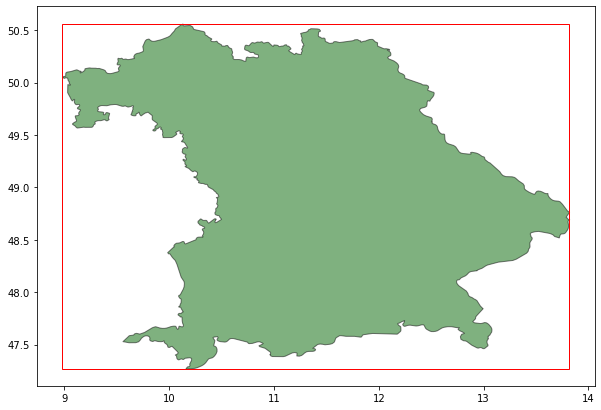

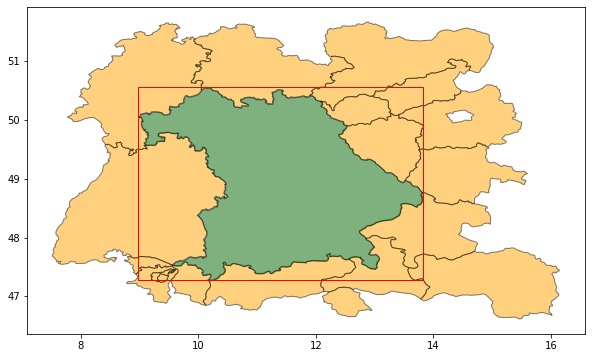

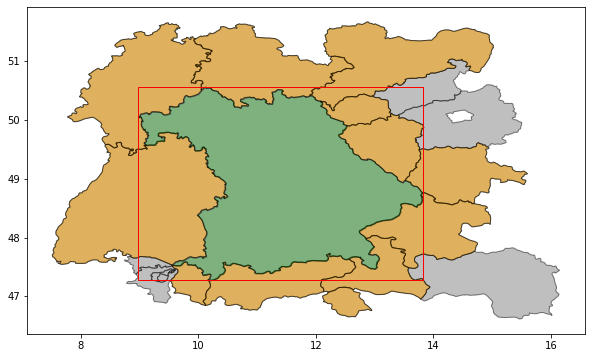

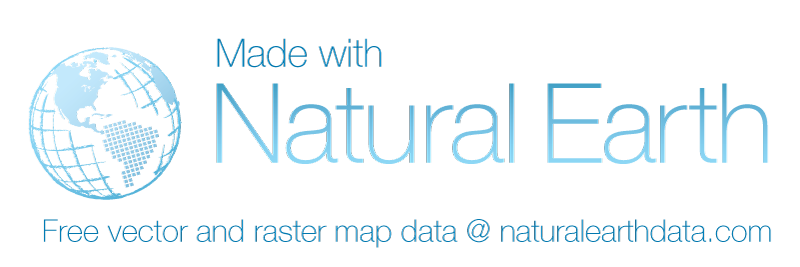

In [11]:
display(Image("fig02_bavaria_and_its_bbox.png"))

display(Image("fig03_bavaria_and_bbox_and_countries_inside_bbox.png"))

display(Image("fig04_bavaria_and_bbox_and_neighbours.png"))

display(Image("https://www.naturalearthdata.com/wp-content/uploads/2009/08/NEV-Logo-color.png",width=200))

## Country or Nation level

In [12]:
save = World.copy() # just to avoid to have to recreate during development

In [13]:
World = save.copy() # just to avoid to have to recreate during development

In [14]:
wIP = IntProgress(min=0,max=len(gfWorld.ADM0_A3.unique()),description="found neighbours")
wIPempty = IntProgress(min=0,max=len(gfWorld.ADM0_A3.unique()),description="no neighbours")
display(HBox([wIP,wIPempty]))

FIELD = "ADM0_A3"

alldata = []
neighbours_adm1_code = []
neighbours_name = []

for adm in gfWorld[FIELD].unique():
    me = gfWorld[gfWorld[FIELD] == adm]
    ggf = gpd.read_file(os.path.join(ROOTFOLDER,"sun/geo/naturalearthdata.com_downloads/ne_10m_admin_0_countries.shp"),bbox=list(me.bounds.values[0]),encoding="utf-8")
    ggf = ggf[ggf[FIELD] != adm]
    if len(ggf) <= 0:
        wIPempty.value += 1
        continue
        
    mask = ggf.apply(lambda row: row['geometry'].touches(me.geometry.values[0]), axis=1)
    if len(ggf[mask])>0:
        neighbours = ggf[mask][FIELD]
        if "ESB" in neighbours:
            break
    
    alldata.append({"me":me[FIELD],"neighbours":neighbours})
    for n in neighbours:
        neighbours_adm1_code.append({"me":adm,"neighbour":n})
        
    for i,row in ggf[ggf[FIELD].isin(neighbours)].iterrows():
        neighbours_name.append({"me_"+FIELD:adm,"neighbour_"+FIELD:row[FIELD],"me_name":me["NAME"].values[0],
                                "me_iso_a2":me["ISO_A2"].values[0],"neighbour_iso_a2":row["ISO_A2"],
                                "me_iso_a3":me["ISO_A3"].values[0],"neighbour_iso_a3":row["ISO_A3"],
                                "neighbour_name":row["NAME"],FIELD:row[FIELD]})
    wIP.value += 1

## Decouple Eurasia/Africa from the Americas

We need to cut French Guiana from mainland France as we want to model infection spread across boundaries. Note we could also tie Denmark to Sweden but the Alesund bridge is an entity that can easily be controlled and would have a different "flavour" than a normal land boundary. Similarly, Istanbul etc.

In [15]:
dfNeighbours = pd.DataFrame(neighbours_name)
dfNeighbours = dfNeighbours.drop(dfNeighbours[(dfNeighbours.me_ADM0_A3 == "FRA")&(dfNeighbours.neighbour_ADM0_A3 == "SUR")].index)
dfNeighbours = dfNeighbours.drop(dfNeighbours[(dfNeighbours.me_ADM0_A3 == "FRA")&(dfNeighbours.neighbour_ADM0_A3 == "BRA")].index)
dfNeighbours = dfNeighbours.drop(dfNeighbours[(dfNeighbours.me_ADM0_A3 == "SUR")&(dfNeighbours.neighbour_ADM0_A3 == "FRA")].index)
dfNeighbours = dfNeighbours.drop(dfNeighbours[(dfNeighbours.me_ADM0_A3 == "BRA")&(dfNeighbours.neighbour_ADM0_A3 == "FRA")].index)
dfNeighbours.head(5)

,me_ADM0_A3,neighbour_ADM0_A3,me_name,me_iso_a2,neighbour_iso_a2,me_iso_a3,neighbour_iso_a3,neighbour_name,ADM0_A3
0,IDN,MYS,Indonesia,ID,MY,IDN,MYS,Malaysia,MYS
1,IDN,TLS,Indonesia,ID,TL,IDN,TLS,Timor-Leste,TLS
2,IDN,PNG,Indonesia,ID,PG,IDN,PNG,Papua New Guinea,PNG
3,MYS,IDN,Malaysia,MY,ID,MYS,IDN,Indonesia,IDN
4,MYS,THA,Malaysia,MY,TH,MYS,THA,Thailand,THA


In [16]:
wIP = IntProgress(min=0,max=len(dfNeighbours))
display(wIP)

for i,row in dfNeighbours.iterrows():
    me = row["me_ADM0_A3"]
    meNode = find_node_by_attribute_value(World,"id",me,kind="country")
    if meNode == None:
        print(end=".")
        continue
    oth = row["neighbour_ADM0_A3"]
    othNode = find_node_by_attribute_value(World,"id",oth,kind="country")
    if othNode == None:
        print("-")
        continue
    World.add_edge(meNode,othNode,kind="geoTouches")
    wIP.value += 1
    
Neighbours = create_subgraph_of_nodes(World,find_nodes_of_kind(World,"country"),find_edges_of_kind(World,"geoTouches"))

IntProgress(value=0, max=670)

In [17]:
wD2 = Dropdown(options=sorted(gfWorld.NAME.unique()),value="Germany")
display(wD2)

Dropdown(index=85, options=('Afghanistan', 'Akrotiri', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Ang…

In [18]:
if not CLOUDPAK:
    nt = pyvis.network.Network("600px","600px",notebook=True)
    nt.from_nx(nx.ego_graph(Neighbours,find_node_by_attribute_value(Neighbours,"name",wD2.value,kind="country")))
    display(nt.show("figure4.html"))
else:
    p = figure(title="World", x_range=(-1.1,1.1), y_range=(-1.1,1.1))
    graph = from_networkx(nx.ego_graph(Neighbours,find_node_by_attribute_value(Neighbours,"name",wD2.value,kind="country")), nx.spring_layout, scale=0.75, center=(0,0))
    
    graph.node_renderer.glyph=Circle(size=15)
    
    node_hover_tool = HoverTool(tooltips=[("index", "@index"), ("name", "@name")])
    p.add_tools(node_hover_tool)
    p.renderers.append(graph)
    
    show(p)

In [19]:
if not CLOUDPAK:
    nt = pyvis.network.Network("1500","1500px",notebook=True)
    nt.from_nx(Neighbours)
    display(nt.show("figure5.html"))
else:
    p = figure(title="World", x_range=(-1.1,1.1), y_range=(-1.1,1.1))
    graph = from_networkx(Neighbours, nx.spring_layout, scale=0.75, center=(0,0))
    
    graph.node_renderer.glyph=Circle(size=15)
    
    node_hover_tool = HoverTool(tooltips=[("index", "@index"), ("name", "@name")])
    p.add_tools(node_hover_tool)
    p.renderers.append(graph)
    
    show(p)

## States

This is a single core implementation which is not speed optimized. At the bottom of this notebook we also compute border lengths and compass direction of neighbours, which is more compute intense, and we make use of multiple cores if available.

This part took 144 seconds on a  AMD Ryzen 9 3950X running at up to 3.5 GHz

In [20]:
save = World.copy()

In [21]:
World = save.copy()

In [22]:
wIP = IntProgress(min=0,max=len(gfStates.iso_3166_2.unique()),description="found neighbours")
wIPempty = IntProgress(min=0,max=len(gfStates.iso_3166_2.unique()),description="no neighbours")
display(HBox([wIP,wIPempty]))

FIELD = "iso_3166_2"

alldata = []
neighbours_adm1_code = []
neighbours_name = []

#for adm in ["DEU-1591"]:#gf.adm1_code.unique():
for adm in gfStates[FIELD].unique():
    me = gfStates[gfStates[FIELD] == adm]
    ggf = gpd.read_file(os.path.join(ROOTFOLDER,"sun/geo/naturalearthdata.com_downloads/ne_10m_admin_1_states_provinces.shp"),bbox=list(me.bounds.values[0]),encoding="utf-8")
    ggf = ggf[ggf[FIELD] != adm]
    if len(ggf) <= 0:
        wIPempty.value += 1
        continue
        
    mask = ggf.apply(lambda row: row['geometry'].touches(me.geometry.values[0]), axis=1)
    if len(ggf[mask])>0:
        neighbours = ggf[mask][FIELD]
        if "ESB" in neighbours:
            break
    
    alldata.append({"me":me[FIELD],"neighbours":neighbours})
    for n in neighbours:
        neighbours_adm1_code.append({"me":adm,"neighbour":n})
        
    for i,row in ggf[ggf[FIELD].isin(neighbours)].iterrows():
        neighbours_name.append({"me_"+FIELD:adm,"neighbour_"+FIELD:row[FIELD],"me_name":me["name"].values[0],
                                #"me_iso_a2":me["ISO_A2"].values[0],"neighbour_iso_a2":row["ISO_A2"],
                                #"me_iso_a3":me["ISO_A3"].values[0],"neighbour_iso_a3":row["ISO_A3"],
                                "neighbour_name":row["name"],FIELD:row[FIELD]})
    wIP.value += 1

In [23]:
dfNeighbours.head()

,me_ADM0_A3,neighbour_ADM0_A3,me_name,me_iso_a2,neighbour_iso_a2,me_iso_a3,neighbour_iso_a3,neighbour_name,ADM0_A3
0,IDN,MYS,Indonesia,ID,MY,IDN,MYS,Malaysia,MYS
1,IDN,TLS,Indonesia,ID,TL,IDN,TLS,Timor-Leste,TLS
2,IDN,PNG,Indonesia,ID,PG,IDN,PNG,Papua New Guinea,PNG
3,MYS,IDN,Malaysia,MY,ID,MYS,IDN,Indonesia,IDN
4,MYS,THA,Malaysia,MY,TH,MYS,THA,Thailand,THA


Now we map the neighbourhood relations onto a second class of edges, which describe neighbourhood relations.

In [24]:
dfNeighbours = pd.DataFrame(neighbours_name)

wIP = IntProgress(min=0,max=len(dfNeighbours)/100)
display(wIP)

counter = 0
for i,row in dfNeighbours.iterrows():
    #me = row["me_iso_a2"]
    me = row["me_iso_3166_2"]
    meNode = find_node_by_attribute_value(World,"id",me,kind="state")
    if meNode == None:
        print(end=".")
        continue
    #oth = row["neighbour_iso_a2"]
    oth = row["neighbour_iso_3166_2"]
    othNode = find_node_by_attribute_value(World,"id",oth,kind="state")
    if me == "DEU":
        print(me,oth,meNode,othNode,end="..")
    if othNode == None:
        print("-")
        continue
    World.add_edge(meNode,othNode,kind="geoTouches")
    counter += 1
    if counter % 100 == 0: # avoid IOPub message rate exceeded.
        wIP.value += 1
    
Neighbours = create_subgraph_of_nodes(World,find_nodes_of_kind(World,"country"),find_edges_of_kind(World,"geoTouches"))

IntProgress(value=0, max=215)

In [25]:
wD3 = Dropdown(options=sorted(gfStates.name.astype(str).unique()),value="Bayern")
display(wD3)

Dropdown(index=440, options=("A'ana", 'Aargau', 'Aberdeen', 'Aberdeenshire', 'Abia', 'Abim', 'Abkhazia', 'Abra…

In [26]:
if not CLOUDPAK:
    nt = pyvis.network.Network("500","500px",notebook=True)
    nt.from_nx(nx.ego_graph(World,find_node_by_attribute_value(World,"name",wD3.value,kind="state")))
    display(nt.show("figure6.html"))
else:
    p = figure(title="World", x_range=(-1.1,1.1), y_range=(-1.1,1.1))
    graph = from_networkx(nx.ego_graph(World,find_node_by_attribute_value(World,"name",wD3.value,kind="state")), nx.spring_layout, scale=0.75, center=(0,0))
    
    graph.node_renderer.glyph=Circle(size=15)
    
    node_hover_tool = HoverTool(tooltips=[("index", "@index"), ("name", "@name")])
    p.add_tools(node_hover_tool)
    p.renderers.append(graph)
    
    show(p)

In [27]:
ROOT = os.path.join(ROOTFOLDER,"mercury/geo/")
Path(ROOT).mkdir(exist_ok=True,parents=True)

with open(os.path.join(ROOT,"world.graph.pickled"),"w+b") as outfile:
    outfile.write(pickle.dumps(World))

In [28]:
dfWorldEdges = nx.to_pandas_edgelist(World)
dfWorldHierarchy = dfWorldEdges[dfWorldEdges.kind=="containsPlace"]
dfWorldNeighbours = dfWorldEdges[dfWorldEdges.kind=="geoTouches"]

world_names = nx.get_node_attributes(World,"name")
dfWorldNames = pd.DataFrame([world_names.values(),world_names.keys()]).transpose().rename(columns={0:"name",1:"node_id"})

alldata = []

for state in find_nodes_of_kind(World,"state"):
    country = dfWorldHierarchy[dfWorldHierarchy.target==state].source.values[0]
    subregion = dfWorldHierarchy[dfWorldHierarchy.target==country].source.values[0]
    continent = dfWorldHierarchy[dfWorldHierarchy.target==subregion].source.values[0]
    
    ddf = dfWorldNeighbours[dfWorldNeighbours.source == state]
    if len(ddf) > 0:
        for i,row in ddf.iterrows():
            alldata.append({"state":World.nodes[state]["name"],
                            "state_id":World.nodes[state]["id"],
                            "state_iso3":World.nodes[state]["iso_3"],
                            "country":World.nodes[country]["name"],
                            "country_sov_a3":World.nodes[country]["sov_a3"],
                            "country_iso_a2":World.nodes[country]["iso_a2"],
                            "country_iso_a3":World.nodes[country]["iso_a3"],
                            "country":World.nodes[country]["name"],
                           "subregion":World.nodes[subregion]["name"],
                           "continent":World.nodes[continent]["name"],
                           "neighbour":World.nodes[row["target"]]["name"],
                           "neighbour_id":World.nodes[row["target"]]["id"],
                           "neighbour_iso3":World.nodes[row["target"]]["iso_3"]})
    else:
        alldata.append({"state":World.nodes[state]["name"],
                        "country":World.nodes[country]["name"],
                       "subregion":World.nodes[subregion]["name"],
                       "continent":World.nodes[continent]["name"],
                       "neighbour":""})

dfCompleteWorldWithNeighbours = pd.DataFrame(alldata)
dfCompleteWorldWithNeighbours.head()

,state,state_id,state_iso3,country,country_sov_a3,country_iso_a2,country_iso_a3,subregion,continent,neighbour,neighbour_id,neighbour_iso3
0,Entre Ríos,AR-E,ARG,Argentina,ARG,AR,ARG,South America,Americas,Paysandú,UY-PA,URY
1,Entre Ríos,AR-E,ARG,Argentina,ARG,AR,ARG,South America,Americas,Artigas,UY-AR,URY
2,Entre Ríos,AR-E,ARG,Argentina,ARG,AR,ARG,South America,Americas,Salto,UY-SA,URY
3,Entre Ríos,AR-E,ARG,Argentina,ARG,AR,ARG,South America,Americas,Corrientes,AR-W,ARG
4,Entre Ríos,AR-E,ARG,Argentina,ARG,AR,ARG,South America,Americas,Buenos Aires,AR-B,ARG


In [29]:
ROOT = os.path.join(ROOTFOLDER,"mercury/geo/")
Path(ROOT).mkdir(exist_ok=True,parents=True)

dfCompleteWorldWithNeighbours.to_csv(os.path.join(ROOT,"complete.world.with.neighbours.csv"),index=False)

# Use country specific names and information

All the computations so far were done using a very high quality model from naturalearth. As we dealt with other data sources (infection data etc) we had to fuse the geo data with those sources, and it became convenient to have consistent naming between those sources and the geo data. We now repeat our computations nation by nation at the resolution given by COVID-19 health data.

## Neighbourhood computation

As we also want to compute the length of the border between two entities, we map the coordinate system such that it can be used to compute meters, not degrees, as reference units. The intended purpose is to compare border lengths for one entity, e.g. what is the relative length of the border between Bavaria and Baden-Württemberg compared to Bavaria and Saxony, for the purpose of COVID-19 risk modelling. As such, the absolute accuracy and ability to compare an equatorial border length with one from a Norther European country is secondary.

In [30]:
print(pyproj.CRS.from_user_input(3857).to_wkt(pretty=True))

PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popular Visualisation Pseudo-Mercator",
        METHOD["Popular Visualisation Pseudo Mercator",
            ID["EPSG",1024]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["False easting",0,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
        PARAMETER["False northing",0,
            LENGTHUNIT["metre",1],
            ID["EPSG",8807]]],
    CS[Cartesian,2],
        AXIS["easting (X)",east,
            ORDER[1],
 

## United Kingdom

This uses data from [arcgis](https://covid19.esriuk.com/datasets/fef73aeaf13c417dadf2fc99abcf8eef_0?geometry=-60.488%2C44.785%2C54.649%2C62.639)

GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    USAGE[
        SCOPE["unknown"],
        AREA["World"],
        BBOX[-90,-180,90,180]],
    ID["EPSG",4326]]


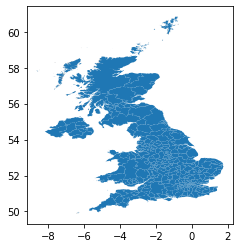

In [31]:
ROOT = os.path.join(ROOTFOLDER,"sun/geo/arcgis.com_datasets")
gdf_uk = gpd.read_file(os.path.join(ROOT,"Local_Authority_Districts__December_2018__Boundaries_UK_BFC.shp"))
print(gdf_uk.crs.to_wkt(pretty=True))
_ = gdf_uk.plot()

In [32]:
def compute_neighbours(geo_filename,id_field,name_field,progress_widget=None):
    """Compute neighbourhood relationships for entries found in an shapefile.
    
    Attributes:
      geo_filename (string): pathname to a shp file (NB shapefiles come in a series of individual files)
      id_field (string): a column name in the geopandas dataframe that is read from geo_filename that identifies the column to be used as unique identifier
      name_field (string): a column name in the geopandas dataframe that is read from geo_filename that identifies the column to be used as entity name
      
    Returns:
      an dataframe containing columns identifier,name,neighbourIdentifier,neighbourName,borderLength, and entries of a entity and, line by line
      a neighbour found by computing a geopandas .touches relationship
    
    Todo:
      * if deemend necessary, handle exceptions, but this is for jupyter interactive use
    """
    gdf = gpd.read_file(geo_filename)
    gdf_3857 = gdf.to_crs(epsg='3857')
    
    alldata = []
    
    if progress_widget:
        progress_widget.min = 0
        progress_widget.max = len(gdf)
        progress_widget.description = os.path.split(geo_filename)[1]
        progress_widget.value = 0
        
    for i,me in gdf.iterrows():
        bbox = me.geometry.bounds
        ggf = gpd.read_file(geo_filename,bbox=bbox).to_crs(epsg='3857')
        ggf = ggf[ggf[id_field] != me[id_field]]
        if len(ggf) <= 0:
            continue
        
        me_3857 = gdf_3857.loc[i]
        
        mask = ggf.apply(lambda row: row['geometry'].touches(me_3857.geometry), axis=1)
        dist = ggf.apply(lambda row: row['geometry'].intersection(me_3857.geometry).length, axis=1)
        if len(ggf[mask])>0:
            neighbour_ids = ggf[mask][id_field]
            neighbour_names = ggf[mask][name_field]
            dist = np.array(dist)
            dist = dist[mask]
            for ii in range(len(ggf[mask])):
                alldata.append({"identifier":me[id_field],"name":me[name_field],
                                "neighbourIdentifier":neighbour_ids.values[ii],"neighbourName":neighbour_names.values[ii],
                                "borderLength":dist[ii]})
        else:
            alldata.append({"identifier":me[id_field]})
        if progress_widget:
            progress_widget.value += 1
         
    return pd.DataFrame(alldata)

In [33]:
%%time
wIP = IntProgress()
display(wIP)
dfNeighbours = compute_neighbours(os.path.join(ROOT,"Local_Authority_Districts__December_2018__Boundaries_UK_BFC.shp"),
                                  "lad18cd",
                                  "lad18nm",
                                  progress_widget=wIP)
ROOT = os.path.join(ROOTFOLDER,"mercury/geo")
Path(ROOT).mkdir(exist_ok=True,parents=True)
dfNeighbours.to_csv(os.path.join(ROOT,"UK.neighbours.csv"),index=False)

IntProgress(value=0)

CPU times: user 1min 45s, sys: 4.03 s, total: 1min 49s
Wall time: 1min 49s


# France

Data are from [osm13.openstreetmap.fr](osm13.openstreetmap.fr), actually. Need one level down.

GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    USAGE[
        SCOPE["unknown"],
        AREA["World"],
        BBOX[-90,-180,90,180]],
    ID["EPSG",4326]]


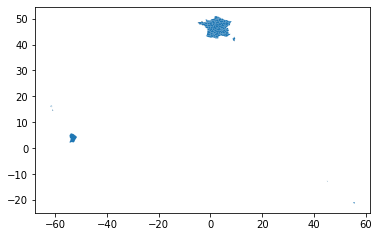

In [34]:
ROOT = os.path.join(ROOTFOLDER,"sun/geo/osm13.openstreetmap.fr")
gdf_fr = gpd.read_file(os.path.join(ROOT,"departements-20180101.shp"))
print(gdf_fr.crs.to_wkt(pretty=True))
_ = gdf_fr.plot()

In [35]:
%%time
wIP = IntProgress()
display(wIP)
dfNeighbours = compute_neighbours(os.path.join(ROOT,"departements-20180101.shp"),
                                  "nuts3",
                                  "nom",
                                  progress_widget=wIP)
ROOT = os.path.join(ROOTFOLDER,"mercury/geo")
Path(ROOT).mkdir(exist_ok=True,parents=True)
dfNeighbours.to_csv(os.path.join(ROOT,"FR.neighbours.csv"),index=False)

IntProgress(value=0)

CPU times: user 42.7 s, sys: 503 ms, total: 43.2 s
Wall time: 43.2 s


# Italy

Data are from Istat.

GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    USAGE[
        SCOPE["unknown"],
        AREA["World"],
        BBOX[-90,-180,90,180]],
    ID["EPSG",4326]]


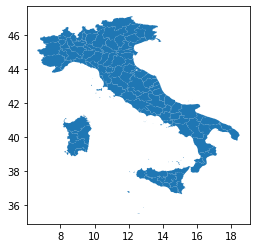

In [36]:
ROOT = os.path.join(ROOTFOLDER,"sun/geo/geojson-italy/geojson")
gdf_it = gpd.read_file(os.path.join(ROOT,"limits_IT_provinces.geojson"))
print(gdf_it.crs.to_wkt(pretty=True))
_ = gdf_it.plot()

In [37]:
%%time
wIP = IntProgress()
display(wIP)
dfNeighbours = compute_neighbours(os.path.join(ROOT,"limits_IT_provinces.geojson"),
                                  "prov_acr",
                                  "prov_name",
                                  progress_widget=wIP)
ROOT = os.path.join(ROOTFOLDER,"mercury/geo")
Path(ROOT).mkdir(exist_ok=True,parents=True)
dfNeighbours.to_csv(os.path.join(ROOT,"IT.neighbours.csv"),index=False)

IntProgress(value=0)

CPU times: user 36.7 s, sys: 306 ms, total: 37 s
Wall time: 34.1 s


# South Korea

Data are from https://github.com/southkorea.

GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    USAGE[
        SCOPE["unknown"],
        AREA["World"],
        BBOX[-90,-180,90,180]],
    ID["EPSG",4326]]


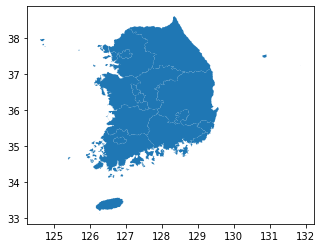

In [38]:
ROOT = os.path.join(ROOTFOLDER,"sun/geo/geojson-south-korea/geojson")
gdf_kr = gpd.read_file(os.path.join(ROOT,"skorea-provinces-2018-geo.json"))
print(gdf_kr.crs.to_wkt(pretty=True))
_ = gdf_kr.plot()

In [39]:
%%time
wIP = IntProgress()
display(wIP)
dfNeighbours = compute_neighbours(os.path.join(ROOT,"skorea-provinces-2018-geo.json"),
                                  "code",
                                  "name_eng",
                                  progress_widget=wIP)
ROOT = os.path.join(ROOTFOLDER,"mercury/geo")
Path(ROOT).mkdir(exist_ok=True,parents=True)
dfNeighbours.to_csv(os.path.join(ROOT,"KR.neighbours.csv"),index=False)

IntProgress(value=0)

CPU times: user 11.2 s, sys: 125 ms, total: 11.3 s
Wall time: 8.61 s


## Germany

Data are [Kreisgrenzen 2019](https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/esri-de-content::kreisgrenzen-2019?geometry=-27.581%2C46.270%2C48.489%2C55.886) and [Bezirke - Berlin](https://opendata-esri-de.opendata.arcgis.com/datasets/9f5d82911d4545c4be1da8cab89f21ae_0). Note that the two files have different coordinate reference systems, so the Berlin Bezirke needs to be converted to `.to_crs("EPSG:4326")`.

Note that the geodata does not contain the correct Landkreis names (e.g., there exists _Augsburg_ and _Augsburg_, one is a city, the other a region), the mapping thus goes via the IdLandkreis numerical key from an actual RKI dataset to the RKI name. Which would be _SK Augsburg_ and _LK Augsburg_.

This was done as part of another notebook and I felt it was too clumsy to represent here and too much work to clean up the code, so, diverting from the approach of providing all data file as downloadable files I will provide it on github.

In [40]:
dfLandkreisBundesland = pd.read_parquet(os.path.join(ROOTFOLDER,"sun/rki/RKI_COVID19.Landkreis-Bundesland.parquet"))     
dfLandkreisBundesland.head()

,IdBundesland,Bundesland,Landkreis,IdLandkreis
0,1,Schleswig-Holstein,SK Flensburg,1001
47,1,Schleswig-Holstein,SK Kiel,1002
335,1,Schleswig-Holstein,SK Lübeck,1003
503,1,Schleswig-Holstein,SK Neumünster,1004
577,1,Schleswig-Holstein,LK Dithmarschen,1051


For reasons unknown, the Germany shape data contains detail sub-State, while it represents Berlin as a single entry. To make things worse, the data for Berlin were in a different location, using a different coordinate system, and an overall different naming of columns or IDs.

In [41]:
ROOT = os.path.join(ROOTFOLDER,"sun/geo/arcgis.com_datasets")

gdf_d = gpd.read_file(os.path.join(ROOT,"Kreisgrenzen_2019.shp"))
gdf_d["IdLandkreis"] = gdf_d.RS.astype(int)

gdf_b = gpd.read_file(os.path.join(ROOT,"Berlin_Bezirke.shp")).to_crs("EPSG:4326").rename(columns={"Land_name":"Bundesland","Gemeinde_n":"GEN"})
gdf_b["IdLandkreis"] = gdf_b.Schluessel.str[:-5]+gdf_b.Schluessel.str[-2:]
gdf_b.rename(columns={"Land_name":"Bundesland","Gemeinde_n":"GEN"},inplace=True)

gdf_d = pd.concat([gdf_d,gdf_b[["IdLandkreis","geometry","GEN"]]])
gdf_d.IdLandkreis = pd.to_numeric(gdf_d.IdLandkreis)
gdf_d = gdf_d.merge(dfLandkreisBundesland[["IdLandkreis","Landkreis"]],on="IdLandkreis")
gdf_d.to_file(os.path.join(ROOT,"germany.shp"))

GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    USAGE[
        SCOPE["unknown"],
        AREA["World"],
        BBOX[-90,-180,90,180]],
    ID["EPSG",4326]]


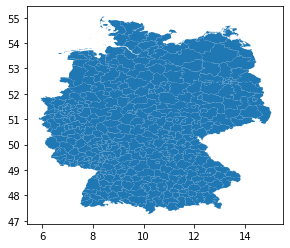

In [42]:
ROOT = os.path.join(ROOTFOLDER,"sun/geo/arcgis.com_datasets")
gdf_de = gpd.read_file(os.path.join(ROOT,"germany.shp"))
print(gdf_de.crs.to_wkt(pretty=True))
_ = gdf_de.plot()

In [43]:
%%time
wIP = IntProgress()
display(wIP)
dfNeighbours = compute_neighbours(os.path.join(ROOT,"germany.shp"),
                                  "IdLandkrei", # for some reason, the column name "Landkreis" got clipped
                                  "Landkreis",
                                  progress_widget=wIP)
ROOT = os.path.join(ROOTFOLDER,"mercury/geo")
Path(ROOT).mkdir(exist_ok=True,parents=True)
dfNeighbours.to_csv(os.path.join(ROOT,"DE.neighbours.csv"),index=False)

IntProgress(value=0)

CPU times: user 26.7 s, sys: 884 ms, total: 27.5 s
Wall time: 25.8 s


# Fun with multiple CPUs

All the above code was patiently making use of a single core. To speed up things in jupyter one would use ipyparallel or similar libraries. This, however, is not necessarily available in a kubernetes environment, and data scientists dislike asking for admin support.

In [44]:
def mp_compute_neighbours(parameters):
    import geopandas as gpd
    import numpy as np
    import os
    import pandas as pd
    
    def direction(point_1,point_2):
        delta_x = point_2[0]-point_1[0]
        delta_y = point_2[1]-point_1[1]
        try:
            degrees = np.arctan2(delta_x, delta_y)/np.pi*180
            if degrees < 0:
                degrees = 360 + degrees
        except:
            degrees = None
        return degrees

    cells = parameters["cells"]
    key_field = parameters["key_field"]
    name_field = parameters["name_field"]
    bboxes = parameters["bboxes"]
    ROOTFOLDER = parameters["rootfolder"]
    alldata = []
    for i,me in cells.iterrows():
        try:
            center_of_universe = me.geometry.centroid.coords[0]
        except: # Antarctica will fire this exception
            continue
        bbox = bboxes[me.adm1_code]
        try:
            ggf = gpd.read_file(os.path.join(ROOTFOLDER,"sun/geo/naturalearthdata.com_downloads/ne_10m_admin_1_states_provinces.shp"),bbox=bbox).to_crs(epsg='3857')
        except:
            continue

        ggf = ggf[ggf[key_field] != me[key_field]]
        if len(ggf) <= 0:
            continue

        mask = ggf.apply(lambda row: row['geometry'].touches(me.geometry), axis=1)
        try:
            dist = ggf.apply(lambda row: row['geometry'].intersection(me.geometry).length, axis=1)
        except:
            dist = np.full(len(mask),-1)
        if len(ggf[mask])>0:
            neighbour_ids = ggf[mask][key_field]
            neighbour_names = ggf[mask][name_field]
            directions = []
            for ii,row in ggf[mask].iterrows():
                try:
                    border_centroid = row["geometry"].centroid.coords[0]
                    directions.append(direction(center_of_universe,border_centroid))
                except:
                    directions.append(np.nan)
            dist = np.array(dist)
            dist = dist[mask]
            for ii in range(len(ggf[mask])):
                alldata.append({"identifier":me[key_field],"name":me[name_field],
                                "neighbourIdentifier":neighbour_ids.values[ii],"neighbourName":neighbour_names.values[ii],
                                "borderLength":dist[ii],
                                "compassDirection":directions[ii]})
    return pd.DataFrame(alldata)

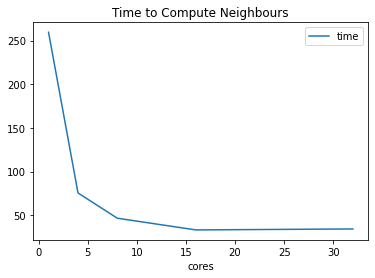

In [45]:
_ = pd.DataFrame({"cores":[32,16,8,4,1],"time":[34.4,33.3,46.7,75.6,259.5]}).plot(x="cores",y="time",title="Time to Compute Neighbours")

In [54]:
# 32 cores 4594 neighbourhood relations in 34.4 seconds
# 16 cores 33.3
# 8 cores 46.7
# 4 cores 75.6
# 1 core 259.5

ROOTFOLDER = "./"
print("We can use {} cores it seems".format(mp.cpu_count()),end="...")

START = time.time()
#gdf = gpd.read_file(os.path.join(ROOTFOLDER,"sun/geo/naturalearthdata.com_downloads/ne_10m_admin_1_states_provinces.shp"))

if __name__ ==  '__main__':
    print("start",end="...")
    gdf = gpd.read_file(os.path.join(ROOTFOLDER,"sun/geo/naturalearthdata.com_downloads/ne_10m_admin_1_states_provinces.shp"))
    print("data file {:.1f}".format(time.time()-START),end="...")
    
    gdf = gdf.to_crs(epsg='3857')
    
    bboxes = {}
    for adm1_code in gdf.adm1_code.values:
        x0,y0,x1,y1 = gdf[gdf.adm1_code == adm1_code].geometry.bounds.values[0]
        bboxes[adm1_code] = (x0,y0,x1,y1)
    print("bounding boxes {:.1f}".format(time.time()-START),end="...")
    
    ncores = mp.cpu_count()
    print("We actually use {} cores".format(ncores),end="...")
    
    slices = np.array_split(gdf,ncores)
    
    data = []
    key_field = "adm1_code"
    name_field = "name"
    for i in range(len(slices)):
        data.append({"cells":slices[i],"geodata":gdf,"key_field":key_field,"name_field":name_field,"bboxes":bboxes,"rootfolder":ROOTFOLDER})
    print("data {:.1f}".format(time.time()-START),end="...")
        
    with open("./workers.py","w+t") as pythonfile:
        pythonfile.write(inspect.getsource(mp_compute_neighbours))
    import workers
    importlib.reload(workers)
    

    p=mp.Pool(processes = ncores)
    print("here we go {:.1f}".format(time.time()-START),end="...")
    output = p.map(workers.mp_compute_neighbours,[d for d in data])
    #os.remove("./workers.py")
    print("{} neighbourhood relations in {:.1f} seconds".format(len(gdf),time.time()-START))

We can use 32 cores it seems...start...data file 0.8...bounding boxes 6.1...We actually use 32 cores...data 6.2...here we go 6.9...

IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


4594 neighbourhood relations in 24.8 seconds


In [55]:
ROOT = os.path.join(ROOTFOLDER,"mercury/geo")
Path(ROOT).mkdir(exist_ok=True,parents=True)
dfNeighbours = pd.DataFrame().append(output)
dfNeighbours.to_csv(os.path.join(ROOT,"world.states.provinces.neighbours.csv"),index=False)